<a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana4_v_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![MAIA banner](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Aprendizaje_refuerzo_profundo_Banner_V1.png)

# <h1><center>Tarea Tutorial - Semana 4 <a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana4_v_2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

<center><h1>REINFORCE</h1></center>

Este tutorial pretende introducir uno de los primeros algoritmos de gradiente de política: REINFORCE. Nuevamente, para ilustrar el funcionamiento y desempeño del algoritmo, se hará uso de un problema basado en un juego de Atari, donde el agente aprenderá directamente de las imágenes del juego. Al mismo tiempo, se profundizará en los beneficios que tiene la utilización de <i>baselines</i> durante el entrenamiento. Para ello, en este notebook se utiliza la librería Gymnasium, que incluye el juego de <i>Atlantis</i>, y una implementación de REINFORCE realizada para PyTorch.


# Tabla de Contenidos
1. [Objetivos de Aprendizaje](#scrollTo=Objetivos_de_Aprendizaje)  
2. [Marco Teórico](#scrollTo=Marco_Te_rico)  
3. [Instalación de Librerías](#scrollTo=Instalaci_n_de_Librer_as)  
4. [Familiarización con el Entorno de Gym](#scrollTo=Familiarizaci_n_con_el_Entorno_de_Gym)  
5. [REINFORCE](#scrollTo=REINFORCE)
6. [Reflexiones Finales](#scrollTo=Reflexiones_Finales)  
7. [Referencias](#scrollTo=Referencias)

# Objetivos de Aprendizaje  

Este tutorial tiene como objetivo:
  

*   Intorducir una familia distinta de algoritmos de aprendizaje por refuerzo: algoritmos de gradiente de política.
*   Comprender las bases teóricas y práticas del funcionamiento del algoritmo de REIFORCE.
*   Exponer las ventajas que tiene la inclusión de <i>baselines</i> dentro del entrenamiento de algoritmos de aprendizaje por refuerzo.

# Marco Teórico  

Hasta ahora, los algoritmos de aprendizaje por refuerzo que se han explorado se basan en aprender y estimar una función de valor para cada acción, por lo que reciben el nombre de métodos de valor-acción (<i>action-value methods</i>). Es decir, las políticas aprendidas en estos métodos dependen directamente de los estimativos de la función de valor-acción ($Q(s,a)$). Sin embargo, existe otra familia de algoritmos que siguen un método de gradiente de política (<i>policy gradient methods</i>), que directamente aprenden una política parametrizada con la capacidad de seleccionar acciones sin la necesidad de estimar una función de valor. Una función de valor puede ser todavía utilizada para aprender el parámetro de la política, pero no se requiere para seleccionar la acción. [1]

Por convención de notación, se utiliza $\theta$ para referirse a un vector de parámetros de la política. Entonces se puede escribir que la política, corresponde a la probabilidad de elegir una acción dado un estado y el vector de parámetros: $\pi(a|s,\theta) = Pr(A_t=a|S_t=s, \theta_t=\theta)$. La forma en que un algoritmo aprende y actualiza el vector de parámetros $\theta$ se basa en el gradiente de alguna métrica de desempeño escalar $J(\theta)$. Este método busca maximizar el desempeño, así que se tiene un ascenso de gradiente en $J$, como se muestra en la Ecuación (1). Se utiliza la notación $\widehat{\nabla J(\theta_t)}$ para denotar que el gradiente en realidad se calcula utilizando un estimativo estocástico. [1]

<center> $\theta_{t+1}=\theta + \alpha \widehat{\nabla J(\theta_t)}$ &emsp;&emsp;&emsp;$(1)$ </center>

Otro elemento importante a tener en cuenta es el teorema de gradiente de política (policy gradient theorem), mostrado en la Ecuación (2). En este teorema, se establece que existe una proporcionalidad entre el gradiente de la función $J(\theta)$ y una expresión analítica dependiente de los parámetros de la política ($\theta$) y que se puede muestrear directamente a partir de la interacción con el ambiente a medida que se mejora la política.
Esto en últimas permite encontrar la máxima dirección de crecimiento de $J(\theta)$ y ajustar los parámetros utilizando una constante de proporcionalidad $\alpha$ como se escribió en la Ecuación (1).

<center> $\nabla J(\theta) \propto \sum_s \mu(s) \sum_a q_\pi(s, a) \nabla \pi(a|s, \theta)$ &emsp;&emsp;&emsp;$(2)$ </center>

El algoritmo de REINFORCE, un algoritmo de gradiente de política, utiliza la regla de actualización de la Ecuación (3), estimando el gradiente estocástico utilizando el retorno $G_t$:

<center> $\theta_{t+1} \doteq \theta_t + \alpha G_t \frac{\nabla \pi(A_t | S_t, \theta_t)}{\pi(A_t | S_t, \theta_t)}$ &emsp;&emsp;&emsp;$(3)$ </center>

En esta actualización, cada incremento es proporcional al producto del retorno $G_t$ y un vector: el gradiente de la probabilidad de escoger la acción tomada dividida por la probabilidad de escoger dicha acción. Este vector corresponde a la dirección en el espacio de parámetros en la cual crece mayormente la probabilidad de escoger la acción $A_t$ en futuras visitas al estado $S_t$. La actualización es proporcional al retorno $G_t$, favoreciendo las acciones que generan mayor recompensa a largo plazo, y es inversamente proporcional a la probabilidad de escoger la acción, no favoreciendo así incorrectamente a acciones que se eligen frecuentemente. Debido a que REINFORCE utiliza el retorno completo desde un tiempo $t$, que incluye todas las recompensas vistas hasta el final del episodio, se dice que entonces REINFORCE es también un método de Monte Carlo. [1]

Finalmente, se consigue una variación de la regla de actualización de REINFORCE si se incluye un <i>baseline</i>, como muestra la Ecuación (4). Incluir un baseline no cambia el valor esperado de la actualización, pero sí puede tener un efecto significativo en la varianza del aprendizaje, reduciéndola significativamente y haciendo el entrenamiento más estable. Para el caso de un MDP, dicho baseline debería variar con el estado, por lo cual una selección típica es utilizar una función de valor de estado $\hat{v}(s,\text{w})$, donde $\text{w}$ es un vector de pesos aprendido por otro algoritmo de valor-acción. [1]

<center> $\theta_{t+1} \doteq \theta_t + \alpha (G_t-b(S_t)) \frac{\nabla \pi(A_t | S_t, \theta_t)}{\pi(A_t | S_t, \theta_t)}$ &emsp;&emsp;&emsp;$(4)$ </center>



# Instalación de Librerías  

En este tutorial se va a utilizar un juego de Atari 2600: <i>Atlantis</i>. Este videojuego hace parte de los ambientes de Atari de la librería Gymnasium. También se requiere instalar correctamente PyTorch para el uso de redes neuronales. Ejecute el siguiente bloque de código para instalar todas las librerías y herramientas necesarias.


In [3]:
#Descarga librerías no incluidas en Colab usando pip
#!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata #Para compatibilidad de PyTorch
!pip3 install torch torchaudio torchvision torchtext torchdata #Instala PyTorch
!pip install ale-py #ALE se utiliza para el ambiente de Atari
!pip install "gymnasium[atari,accept-rom-license]" stable-baselines3 autorom renderlab -q #Gymnasium, envs de Atari y ROM
!AutoROM --accept-license
!pip install renderlab #usado para renderizar gym
!pip install stable_baselines3 #Stable Baselines3 -> Framework de Reinforcement Learning

#Importa estas librerías
import torch #Importa herramientas de PyTorch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium #importa la libreria de gymnasium con las simulaciones
import renderlab #importa renderlab para los videos
import stable_baselines3 #importa Stable Baselines3
from stable_baselines3.common.env_util import make_atari_env #importa make_atari_env para escala de grises
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack #importa VecFrameStack para apilar frames y acelerar así el entrenamiento
import ale_py #importa ale para los ambientes de Atari
from gymnasium.wrappers import TimeLimit #importa timelimit para acortar los episodios
from collections import deque #importa para ajustar los videos con VecFrameStack
import cv2 #importa para ajustar los videos con VecFrameStack

#!Importante:
gymnasium.register_envs(ale_py) #Hay que registrar los entornos de ALE manualmente!!!

#Importa otras librerías básicas
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import sys
import argparse
from itertools import count

#Limpia los registros generados
from IPython.display import clear_output
clear_output()
print("Todas las librerías han sido instaladas correctamente.")

Todas las librerías han sido instaladas correctamente.


# Familiarización con el Entorno de Gym

## Ejemplo



In [4]:
#Parámetros del ambiente
env_render = gymnasium.make("ALE/Atlantis-v5", render_mode="rgb_array", mode=0, difficulty=0) #Se crea el ambiente.
env_render = renderlab.RenderFrame(env_render, "./output") #Se crea una copia que se pueda renderizar con renderlab

terminated = False #Inicializa una condición para el loop
truncated = False #Inicializa una condición para el loop
total_reward=0 #Inicializa contador del retorno

obs , info = env_render.reset() #Se reinicia el estado para comenzar. En obs se almacena el estado observado
while not (terminated or truncated): #Simula hasta que termine la partida
  action = random.choice([0, 1, 2, 3])  # Elige una acción aleatoria
  obs, reward, terminated, truncated, info = env_render.step(action) #Da el paso
  total_reward += reward #Suma recompensa

print("Recompensa obtenida en el episodio:",total_reward) #Se imprime la recompensa obtenida
print("\n\n")

env_render.play() #Con esta función se obtiene el video de la simulación

Recompensa obtenida en el episodio: 22200.0



Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [ ]:
# Ejecute una partida con dificultad 1 y modo 7

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

#REINFORCE



In [16]:
class Policy_atla(nn.Module):
  """Esta clase define la red neuronal usada para el juego de Atlantis"""
  def __init__(self):
    super(Policy_atla, self).__init__()
    #Crea una red convolucional de 3 capas.
    #Entrada: 2 frames en escala de grises de tamaño 84x84
    #Salida: Distribución de probabilidad sobre 4 acciones posibles
    self.conv1 = nn.Conv2d(2, 32, kernel_size=8, stride=4)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.fc1 = nn.Linear(64 * 7 * 7, 512)
    self.fc2 = nn.Linear(512, 4)
    self.saved_log_probs = []
    self.rewards = []
  def forward(self, x):
    #Flujo de la red neuronal
    #Aplica una función SOFTMAX en la salida para retornar probabilidades
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.reshape(x.size(0), -1)
    x = F.relu(self.fc1(x))
    return F.softmax(self.fc2(x), dim=1)

class ValueNetwork(nn.Module):
  """Esta clase define la red neuronal usada para la estimación de la función de valor (baseline)"""
  def __init__(self):
    #Crea una red convolucional de 3 capas.
    #Entrada: 2 frames en escala de grises de tamaño 84x84
    #Salida: Éstimación de la función de valor en el estado
    super(ValueNetwork, self).__init__()
    self.conv1 = nn.Conv2d(2, 32, kernel_size=8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 512)
    self.fc2 = nn.Linear(512, 1)
  def forward(self, x):
    #Flujo de la red neuronal
    #Retorna un solo valor escalar que representa el valor esperado del estado actual
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.reshape(x.size(0), -1)
    x = F.relu(self.fc1(x))
    return self.fc2(x).squeeze(-1)

class REINFORCE_atla:
  """Esta clase inicializa el agente, lo entrena y realiza una validación"""
  def __init__(self, use_baseline=0, learning_rate_reinforce=1e-5, learning_rate_baseline=1e-4, gamma=1, max_steps_per_episode=5000, max_training_episodes=1500):
    #INPUTS:
    #use_baseline: Indica si usar o no baseline y qué baseline usar
    #(0: No usar Baseline, 1: Usar normalización de recompensas, 2: Usar promedio de recompensas como baseline, 3: Usar función de valor como baseline)
    #learning_rate_reinforce: Tasa de aprendizaje del algoritmo de Reinforce
    #learning_rate_baseline: Tasa de aprendizaje para el estimador de la función de valor
    #gamma: factor de descuento
    #max_steps_per_episode: Máxima duración de un episodio
    #max_training_episodes: Cantidad máxima de episodios para entrenar

    #Algunos parámetros
    self.gamma=gamma
    self.seed=543
    self.log_interval=20 #Cada cuántos episodios se imprime un logger en pantalla
    self.max_steps_per_episode=max_steps_per_episode #Cantidad máxima de pasos por episodio (limitar duración)
    self.max_training_episodes=max_training_episodes #Cantidad máxima de episodios para entrenamiento (limitar duración)
    self.use_baseline=use_baseline #Usar o no baseline y de qué tipo (0, 1, 2 o 3)

    #Crea el ambiente con escala de grises y apilando 2 frames
    self.env = make_atari_env("ALE/Atlantis-v5",n_envs=1,seed=0,env_kwargs={"mode": 0, "difficulty": 0})
    self.env = VecFrameStack(self.env, n_stack=2)

    #Inicializa ambiente
    obs = self.env.reset()
    torch.manual_seed(self.seed)

    #Inicializa variables para almacenar estados/datos
    self.last_state = obs
    self.last_states = []
    self.all_episodes_rewards = []

    input_dim = obs.shape[0]
    if hasattr(self.env.action_space, 'n'):
      output_dim = self.env.action_space.n
    else:
      raise ValueError("El espacio de acciones debe ser discreto.")

    #Inicializa la política (red neuronal)
    self.policy = Policy_atla()
    self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate_reinforce)  # learning_Rate más bajo suele funcionar mejor en imágenes
    self.eps = np.finfo(np.float32).eps.item()

    #Inicializa el estimador de la función de valor (red neuronal, si se usa use_baseline=3)
    self.value_function_estimator = ValueNetwork()
    self.value_function_estimator_optimizer = optim.Adam(self.value_function_estimator.parameters(), lr=learning_rate_baseline)


  def select_action(self, state, epsilon=0.15):
    #Esta función selecciona una acción en cada paso de la simulación
    #INPUTS:
    #state: el estado correspondiente a la observación del ambiente (framestack de 2 frames)
    #epsilon: una tasa de exploración adicional

    #Convierte la imagen en un tensor de PyTorch. Dimension original: (1, 84, 84, 2)
    state = torch.from_numpy(state).float()
    state = state.permute(0, 3, 1, 2)  #Dimension final: (1, 2, 84, 84)

    if random.random() < epsilon:  # Con probabilidad epsilon, se elige acción aleatoria
      action = random.choice([0, 1, 2, 3])
    else:
      #La red neuronal elige una acción
      probs = self.policy(state)
      m = Categorical(probs)
      action = m.sample()
      self.policy.saved_log_probs.append(m.log_prob(action))
      action = action.item()

    #Guarda estados para uso de baseline
    self.last_state = state
    self.last_states.append(state)

    return action #Retorna la acción escogida (0, 1, 2 o 3)


  def finish_episode(self):
    #Al final de cada episodio hace una actualización de la política (Monte Carlo)

    #Inicializa valores
    R = 0
    policy_loss = []
    returns = deque()

    #Obtiene el retorno con todas las recompensas del episodio teniendo en cuenta el factor de descuento
    for r in self.policy.rewards[::-1]:
        R = r + self.gamma * R
        returns.appendleft(R)
    returns = np.array(returns)
    returns = torch.tensor(returns)

    #Caso de Baseline
    if(self.use_baseline==3): #Si use_baseline==3, usa la aproximación de función de valor
      state_batch = torch.cat(self.last_states, dim=0)
      value_preds = self.value_function_estimator(state_batch).squeeze().detach()
      advantages = returns - value_preds
    elif(self.use_baseline==2): #Si use_baseline==2, usa un promedio de los retornos vistos
      advantages = returns - returns.mean()
    elif(self.use_baseline==1): #Si use_baseline==1, sólo aplica una normalización del retorno
      if len(returns) > 1 and returns.std() > 1e-6:
        returns = (returns - returns.mean()) / (returns.std() + self.eps)
      else:
        returns = returns - returns.mean()
      advantages = returns
    else: #En cualquier otro caso (#Si use_baseline==0), no usa baseline
      advantages = returns

    #Cálculo de pérdida de la política
    for log_prob, advantage in zip(self.policy.saved_log_probs, advantages):
        if log_prob is not None:
            policy_loss.append(-log_prob * advantage)

    #Retropropagación de la red neuronal
    self.optimizer.zero_grad()
    if len(policy_loss) == 0:
        return
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    self.optimizer.step()

    #Si use_baseline==3, también actualiza la red neuronal que estima la función de valor
    if(self.use_baseline==3):
      self.value_function_estimator_optimizer.zero_grad()
      predicted_values = self.value_function_estimator(state_batch).squeeze()
      value_function_estimator_loss = F.mse_loss(predicted_values, returns)
      value_function_estimator_loss.backward()
      self.value_function_estimator_optimizer.step()
      self.last_states.clear()

    #Limpia las variables temporales
    del self.policy.rewards[:]
    del self.policy.saved_log_probs[:]


  def train(self):
    #Esta función ejecuta todo el entrenamiento

    #Inicializa variables
    running_reward = 0
    cumulative_episodes_reward=0

    for i_episode in range(1,self.max_training_episodes+1): #Ejecuta como máximo max_steps_per_episode para que el entrenamiento no sea infinito
        #Inicializa el ambiente y la recompensa total del episodio
        state = self.env.reset()
        ep_reward = 0
        for t in range(1, self.max_steps_per_episode):  #Cada episodio tiene un máximo de pasos para que no pueda quedarse hasta el infinito
          action = self.select_action(state, epsilon=0) #Elige acción
          state, reward, done, _ = self.env.step([action])
          self.policy.rewards.append(reward[0]) #Almacena recompensa para actualizaciones
          ep_reward += np.array(reward).item()
          if done: #Si pierde, termina el episodio
            break

        #Después de terminar el episodio, calcula running_reward, y actualiza variables para el promedio y grafica
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        cumulative_episodes_reward += ep_reward
        self.all_episodes_rewards.append(ep_reward*100)

        self.finish_episode()

        #Imprime estadísticas en pantalla
        if i_episode % self.log_interval == 0:
          print('Episode {} completed.\tLast Reward: {:.2f}\tLast 20 Episodes Average Reward: {:.2f}\t\tRunning reward: {:.2f}'.format(
                  i_episode, ep_reward*100, cumulative_episodes_reward*100/20, running_reward*100)) #Las recompensas están divididas por 100 en el ambiente
          cumulative_episodes_reward=0
        #Cuando running_reward pasa un umbral da por terminado el entrenamiento
        if running_reward > 5:
          print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward*100, t))
          break

  def graph_training(self):
    #Esta función realiza una grafica de la recompensa a lo largo de los episodios de entrenamiento
    episodes = list(range(1, len(self.all_episodes_rewards) + 1))

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, self.all_episodes_rewards, color='orange')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa total')
    plt.title('Curva de aprendizaje: Recompensa vs. Episodios')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

  def video(self):
    #Crea un entorno para renderizar
    env = gymnasium.make("ALE/Atlantis-v5", render_mode="rgb_array", mode=0, difficulty=0)
    env = renderlab.RenderFrame(env, "./output")

    #Frame stack manual para el modelo, para que el video no salga cortado (se apilan dos frame, en escala de gris, tamano 84x84)
    frame_stack = deque(maxlen=2)

    #Reset inicial
    obs, info = env.reset()

    #Procesa una copia del frame solo para el modelo
    def preprocess(obs):
      gray = obs.mean(axis=2).astype(np.uint8)  # escala de grises
      resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA) #redimensiona
      return resized

    #Realiza el framestack
    preprocessed = preprocess(obs)
    for _ in range(2):
      frame_stack.append(preprocessed)

    #Inicialización del ambiente
    terminated = False
    truncated = False
    total_reward = 0

    #Loop de simulacion
    while not (terminated or truncated):
        #Convierte frames a la forma (2, 84, 84)
        stacked_obs = np.stack(frame_stack, axis=0)

        #Cambia el orden de las dimensiones a (1, 2, 84, 84) (batch_size, channels, height, width)
        stacked_obs = np.expand_dims(stacked_obs, axis=0)  # (1, 2, 84, 84)
        stacked_obs = np.transpose(stacked_obs, (0, 2, 3, 1))  # (1, 84, 84, 2)

        #Elige la accion
        action=self.select_action(stacked_obs, epsilon=0) #especifica que no hay exploracion

        #Avanza en el entorno real manteniendo la continuidad en el video
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        #Actualiza el stack solo para el modelo
        preprocessed = preprocess(obs)
        frame_stack.append(preprocessed)

    #Muestra la recompensa total obtenida y el video
    print("\n\n")
    print("Recompensa obtenida en el episodio:", total_reward)
    env.play()

Entrenamiento SIN baseline.


Episode 20 completed.	Last Reward: 100.00	Last 20 Episodes Average Reward: 80.00		Running reward: 57.30
Episode 40 completed.	Last Reward: 300.00	Last 20 Episodes Average Reward: 155.00		Running reward: 120.56
Episode 60 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 105.00		Running reward: 112.21
Episode 80 completed.	Last Reward: 200.00	Last 20 Episodes Average Reward: 150.00		Running reward: 134.29
Episode 100 completed.	Last Reward: 300.00	Last 20 Episodes Average Reward: 125.00		Running reward: 134.45
Episode 120 completed.	Last Reward: 200.00	Last 20 Episodes Average Reward: 175.00		Running reward: 148.50
Episode 140 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 105.00		Running reward: 113.87
Episode 160 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 170.00		Running reward: 158.40
Episode 180 completed.	Last Reward: 100.00	Last 20 Episodes Average Reward: 175.00		Running reward: 171.49
Episode 200 complet

  plt.legend()



Episode 1500 completed.	Last Reward: 200.00	Last 20 Episodes Average Reward: 145.00		Running reward: 146.24


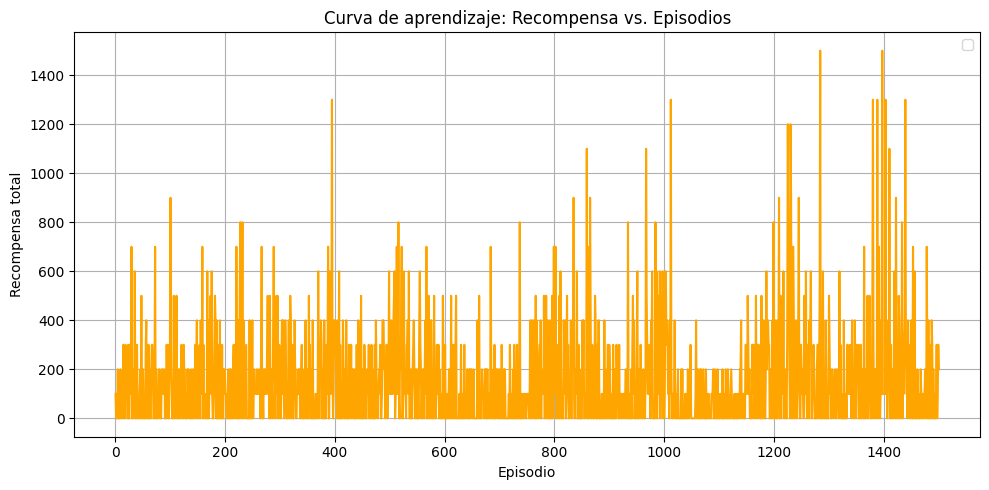




Recompensa obtenida en el episodio: 35600.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [9]:
print("Entrenamiento SIN baseline.")
print("\n")
agente_atlantis0=REINFORCE_atla(use_baseline=0,max_steps_per_episode=5000, max_training_episodes=1500) #Inicializa agente
agente_atlantis0.train() #Entrena
agente_atlantis0.graph_training() #Grafica curva de aprendizaje
agente_atlantis0.video() #Validación en video
torch.save(agente_atlantis0.policy.state_dict(), 'policy_agente0.pth') #Salva la política

Entrenamiento SIN baseline pero con Noramlización de recompensas.


Episode 20 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 115.00		Running reward: 86.85
Episode 40 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 140.00		Running reward: 122.69
Episode 60 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 130.00		Running reward: 121.68
Episode 80 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 120.00		Running reward: 121.82
Episode 100 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 110.00		Running reward: 108.87
Episode 120 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 65.00		Running reward: 75.39
Episode 140 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 80.00		Running reward: 82.79
Episode 160 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 35.00		Running reward: 52.24
Episode 180 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 50.00		Running reward: 48.23


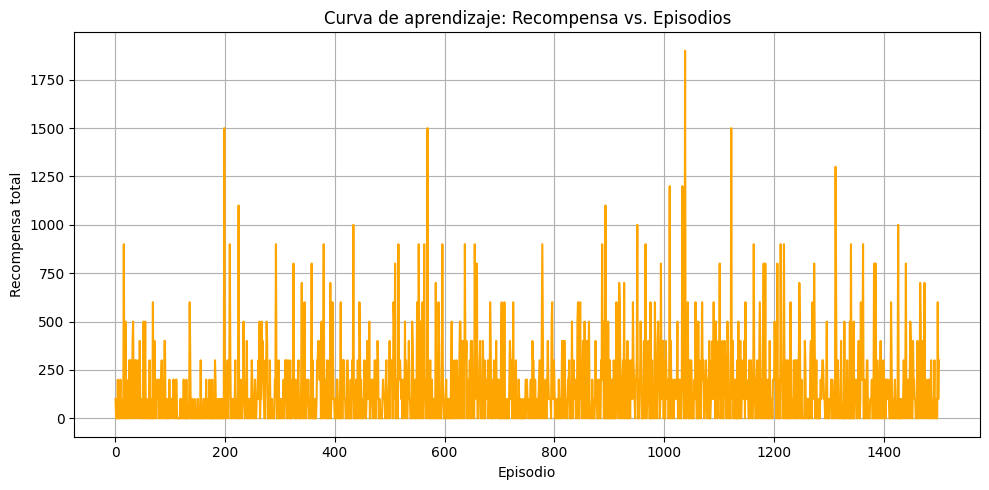




Recompensa obtenida en el episodio: 28900.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  96%|█████████▌| 1448/1509 [00:01<00:00, 767.18it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1747282004.716878.mp4, 100800 bytes wanted but 0 bytes read,at frame 1508/1509, at time 50.27/50.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                                 

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [17]:
print("Entrenamiento SIN baseline pero con Noramlización de recompensas.")
print("\n")
agente_atlantis1=REINFORCE_atla(use_baseline=1,max_steps_per_episode=5000, max_training_episodes=1500) #Inicializa agente
agente_atlantis1.train() #Entrena
agente_atlantis1.graph_training() #Grafica curva de aprendizaje
agente_atlantis1.video() #Validación en video
torch.save(agente_atlantis1.policy.state_dict(), 'policy_agente1.pth') #Salva la política

In [18]:
print("Entrenamiento CON baseline calculado como el promedio de los retornos.")
print("\n")
agente_atlantis2=REINFORCE_atla(use_baseline=2,max_steps_per_episode=5000, max_training_episodes=1500) #Inicializa agente
agente_atlantis2.train() #Entrena
agente_atlantis2.graph_training() #Grafica curva de aprendizaje
agente_atlantis2.video() #Validación en video
torch.save(agente_atlantis2.policy.state_dict(), 'policy_agente2.pth') #Salva la política

Entrenamiento CON baseline calculado como el promedio de los retornos.


Episode 20 completed.	Last Reward: 0.00	Last 20 Episodes Average Reward: 115.00		Running reward: 86.85


KeyboardInterrupt: 

In [ ]:
print("Entrenamiento CON baseline usando estimación de la función de valor.")
print("\n")
agente_atlantis3=REINFORCE_atla(use_baseline=2,max_steps_per_episode=5000, max_training_episodes=1500) #Inicializa agente
agente_atlantis3.train() #Entrena
agente_atlantis3.graph_training() #Grafica curva de aprendizaje
agente_atlantis3.video() #Validación en video
torch.save(agente_atlantis3.policy.state_dict(), 'policy_agente3.pth') #Salva la política

# Reflexiones Finales






# Referencias

[1] Sutton, R. S. and Barto, A. G. (2018). Reinforcement Learning: An Introduction. The MIT Press, second edition.

[2] Gym Documentation, Atlantis. `https://gymnasium.farama.org/v0.28.1/environments/atari/atlantis/`

[3] PyTorch REINFORCE example. `https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py`